In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
import time

## Data Loading

In [2]:
# creating spark session
spark = SparkSession.builder \
    .appName("KafkaToSpark") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0") \
    .getOrCreate()

In [3]:
# defining schema for the data
schema = StructType([
    StructField("EventType", StringType()),
    StructField("Timestamp", TimestampType()),
    StructField("Location", StringType()),
    StructField("Severity", StringType()),
    StructField("Details", StringType())
])

In [4]:
# reading the data from the kafka stream
df_read = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "44.201.154.178:9092") \
  .option("subscribe", "health_events") \
  .option("startingOffsets", "earliest") \
  .load()

In [5]:
df_read.dtypes # checking the data types

[('key', 'binary'),
 ('value', 'binary'),
 ('topic', 'string'),
 ('partition', 'int'),
 ('offset', 'bigint'),
 ('timestamp', 'timestamp'),
 ('timestampType', 'int')]

In [6]:
# converting the data to string and then to json
df_read = df_read.selectExpr("CAST(value AS STRING)")  
df_read = df_read.select(from_json("value", schema).alias("data")).select("data.*")  

In [7]:
# writing the data to memory
query = df_read.writeStream \
    .queryName("health_events_view") \
    .outputMode("append") \
    .format("memory") \
    .start()

time.sleep(90)
query.stop()

In [8]:
# querying the data from memory
df= spark.sql("SELECT * FROM health_events_view")
df.show(5)

+------------------+-------------------+-----------+--------+--------------------+
|         EventType|          Timestamp|   Location|Severity|             Details|
+------------------+-------------------+-----------+--------+--------------------+
|   routine_checkup|2024-04-03 02:14:33|      Paris|     low|This is a simulat...|
|emergency_incident|2024-04-03 02:14:52|     Boston|    high|This is a simulat...|
|hospital_admission|2024-04-03 02:15:12|Los Angeles|  medium|This is a simulat...|
|emergency_incident|2024-04-03 02:15:29|Los Angeles|    high|This is a simulat...|
|   routine_checkup|2024-04-03 02:15:47|      Paris|     low|This is a simulat...|
+------------------+-------------------+-----------+--------+--------------------+
only showing top 5 rows



In [9]:
print(df.count())

103640


In [10]:
df =df.drop("Details") # dropping the details column as it is not required

### Adding date and time columns

In [11]:
from pyspark.sql.functions import date_format

# creating date and time columns
df = df.withColumn("Date", date_format("Timestamp", "yyyy-MM-dd"))
df = df.withColumn("Time", date_format("Timestamp", "HH:mm:ss"))

df.show(10)

+------------------+-------------------+-----------+--------+----------+--------+
|         EventType|          Timestamp|   Location|Severity|      Date|    Time|
+------------------+-------------------+-----------+--------+----------+--------+
|   routine_checkup|2024-04-03 02:14:33|      Paris|     low|2024-04-03|02:14:33|
|emergency_incident|2024-04-03 02:14:52|     Boston|    high|2024-04-03|02:14:52|
|hospital_admission|2024-04-03 02:15:12|Los Angeles|  medium|2024-04-03|02:15:12|
|emergency_incident|2024-04-03 02:15:29|Los Angeles|    high|2024-04-03|02:15:29|
|   routine_checkup|2024-04-03 02:15:47|      Paris|     low|2024-04-03|02:15:47|
|       vaccination|2024-04-03 02:15:47|Los Angeles|     low|2024-04-03|02:15:47|
|hospital_admission|2024-04-03 02:15:57|     Boston|    high|2024-04-03|02:15:57|
|   routine_checkup|2024-04-03 02:16:06|     Berlin|     low|2024-04-03|02:16:06|
|    health_mention|2024-04-03 02:16:10|   New York|     low|2024-04-03|02:16:10|
|hospital_admiss

## Data Analysis

We can observe the count of events for each type and at the locations.

In [12]:

# Event Frequency by Type
event_type_freq = df.groupBy("EventType").count()
event_type_freq.show()

# Geographical Distribution
location_freq = df.groupBy("Location").count()
location_freq.show()

# Cross-tabulation of Event Types and Locations
event_location_matrix = df.crosstab("EventType", "Location")
event_location_matrix.show()

+--------------------+-----+
|           EventType|count|
+--------------------+-----+
|  hospital_admission|16991|
|      health_mention|17181|
|general_health_re...|17421|
|         vaccination|17445|
|     routine_checkup|17393|
|  emergency_incident|17209|
+--------------------+-----+

+-----------+-----+
|   Location|count|
+-----------+-----+
|Los Angeles|17272|
|     Berlin|17453|
|     London|17335|
|      Paris|17100|
|   New York|17285|
|     Boston|17195|
+-----------+-----+

+--------------------+------+------+------+-----------+--------+-----+
|  EventType_Location|Berlin|Boston|London|Los Angeles|New York|Paris|
+--------------------+------+------+------+-----------+--------+-----+
|  emergency_incident|  2880|  2903|  2855|       2843|    2836| 2892|
|     routine_checkup|  2887|  2865|  2940|       2971|    2856| 2874|
|general_health_re...|  2928|  2907|  2944|       2913|    2888| 2841|
|         vaccination|  3001|  2895|  2902|       2785|    2937| 2925|
|  hospital

## Visualizations

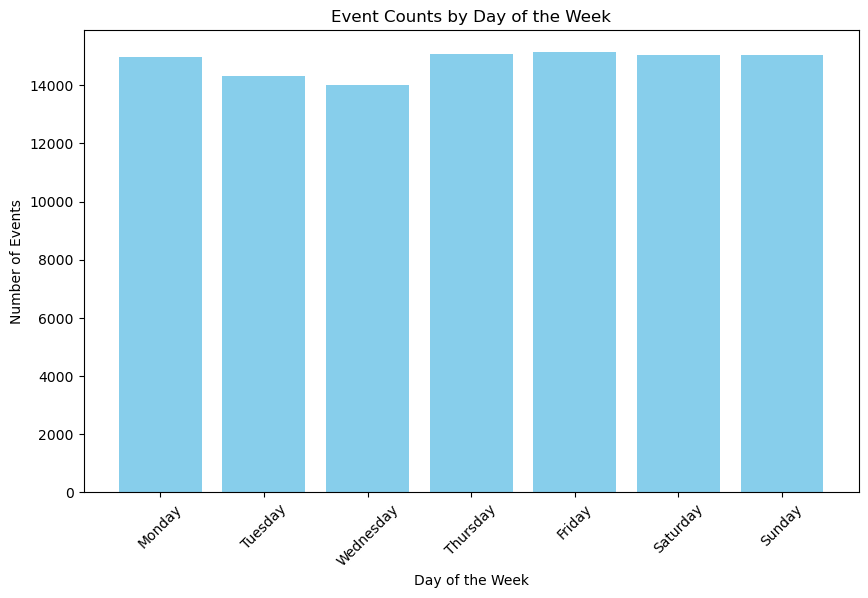

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import dayofweek, date_format
import matplotlib.pyplot as plt
import pandas as pd

# Day of the Week Analysis
df = df.withColumn("DayOfWeek", date_format("Timestamp", "EEEE"))
day_of_week_counts = df.groupBy("DayOfWeek").count()
day_of_week_counts_pd = day_of_week_counts.toPandas()

# Sorting the days of the week
sorter = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_of_week_counts_pd['DayOfWeek'] = pd.Categorical(day_of_week_counts_pd['DayOfWeek'], categories=sorter, ordered=True)
day_of_week_counts_pd.sort_values('DayOfWeek', inplace=True)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(day_of_week_counts_pd['DayOfWeek'], day_of_week_counts_pd['count'], color='skyblue')
plt.title('Event Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.show()


The above graph shows almost similar event frequency across the week.

### Individual Event Frequency across the week

In the below visualization, even on a detailed scale, we can observe a similar trend for all the events as seen in the aggregate event over-the-week spread.

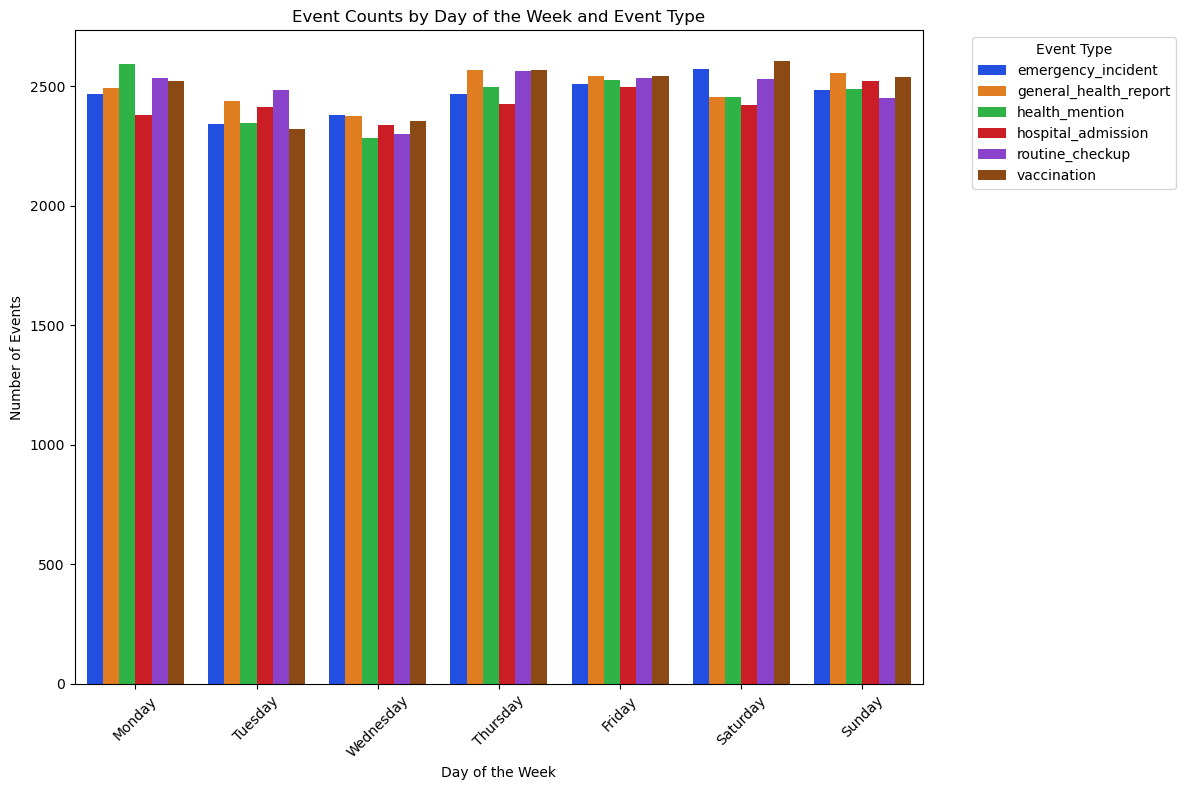

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import date_format
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Day of the Week and Event Type Analysis
df = df.withColumn("DayOfWeek", date_format("Timestamp", "EEEE"))
day_of_week_event_type_counts = df.groupBy("DayOfWeek", "EventType").count()
dow_event_type_pd = day_of_week_event_type_counts.toPandas()

# Sorting the days of the week and event types
sorter = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_event_type_pd['DayOfWeek'] = pd.Categorical(dow_event_type_pd['DayOfWeek'], categories=sorter, ordered=True)
dow_event_type_pd.sort_values(['DayOfWeek', 'EventType'], inplace=True)

# Plotting the data
plt.figure(figsize=(12, 8))
sns.barplot(data=dow_event_type_pd, x='DayOfWeek', y='count', hue='EventType', palette='bright')
plt.title('Event Counts by Day of the Week and Event Type')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  
plt.show()


### Individual Event Severity Frequency across the week

In the below visualization we can observe that medium severity events occur the most with relatively lesser high and low cases. This makes sense as medium cases would be average cases.

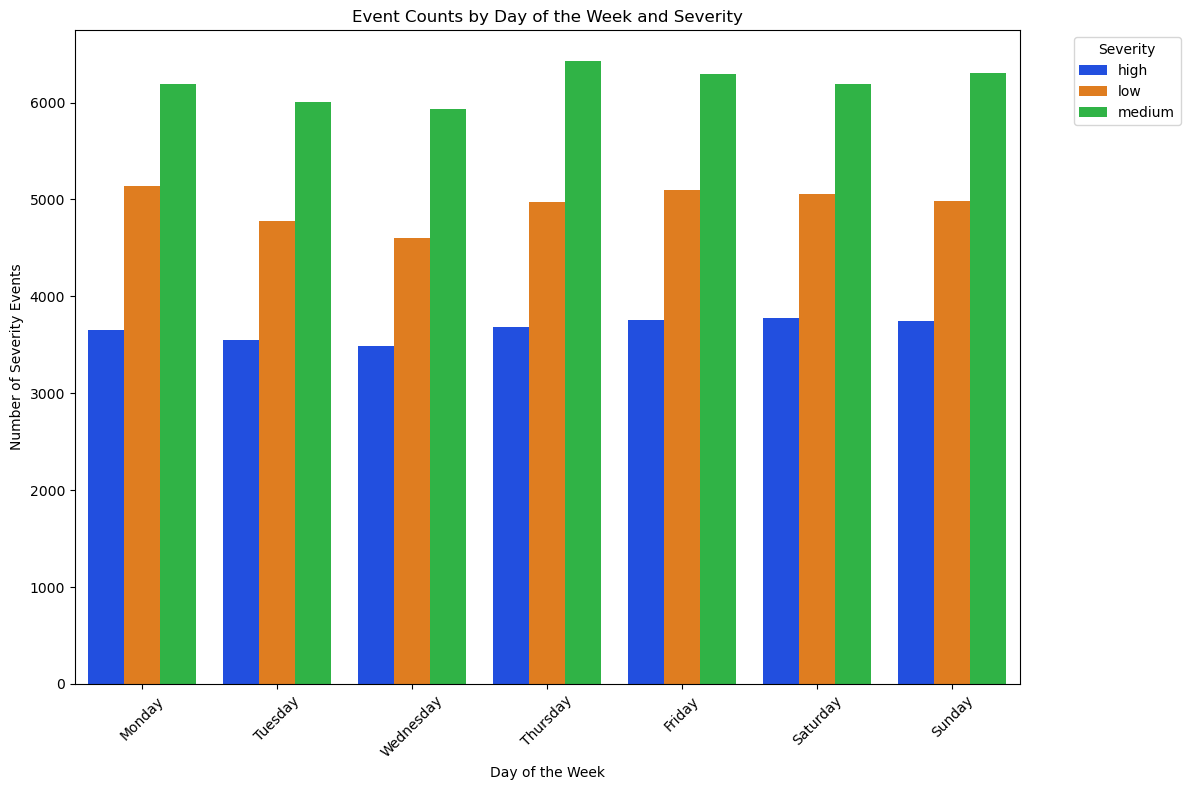

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import date_format
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Day of the Week and Severity Analysis
df = df.withColumn("DayOfWeek", date_format("Timestamp", "EEEE"))
day_of_week_severity_counts = df.groupBy("DayOfWeek", "Severity").count()
dow_event_type_pd = day_of_week_severity_counts.toPandas()

# Sorting the days of the week and severity levels
sorter = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_event_type_pd['DayOfWeek'] = pd.Categorical(dow_event_type_pd['DayOfWeek'], categories=sorter, ordered=True)
dow_event_type_pd.sort_values(['DayOfWeek', 'Severity'], inplace=True)

# Plotting the data
plt.figure(figsize=(12, 8))
sns.barplot(data=dow_event_type_pd, x='DayOfWeek', y='count', hue='Severity', palette='bright')
plt.title('Event Counts by Day of the Week and Severity')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Severity Events')
plt.xticks(rotation=45)
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()


### Event Severity Analyses across hours of the day

Learning from previous analyses we know that medium severity events have most frequency followed by low and high severity events. Converging onto it, we can also observe below that from morning to evening (i.e.4am to 9pm) there is human activity which probably is the cause of event occurence.

Another interesting observation is that medium/average severity events increase during dusk/evening time, which might be as people are still active and it is night-time thus prone to incidents.

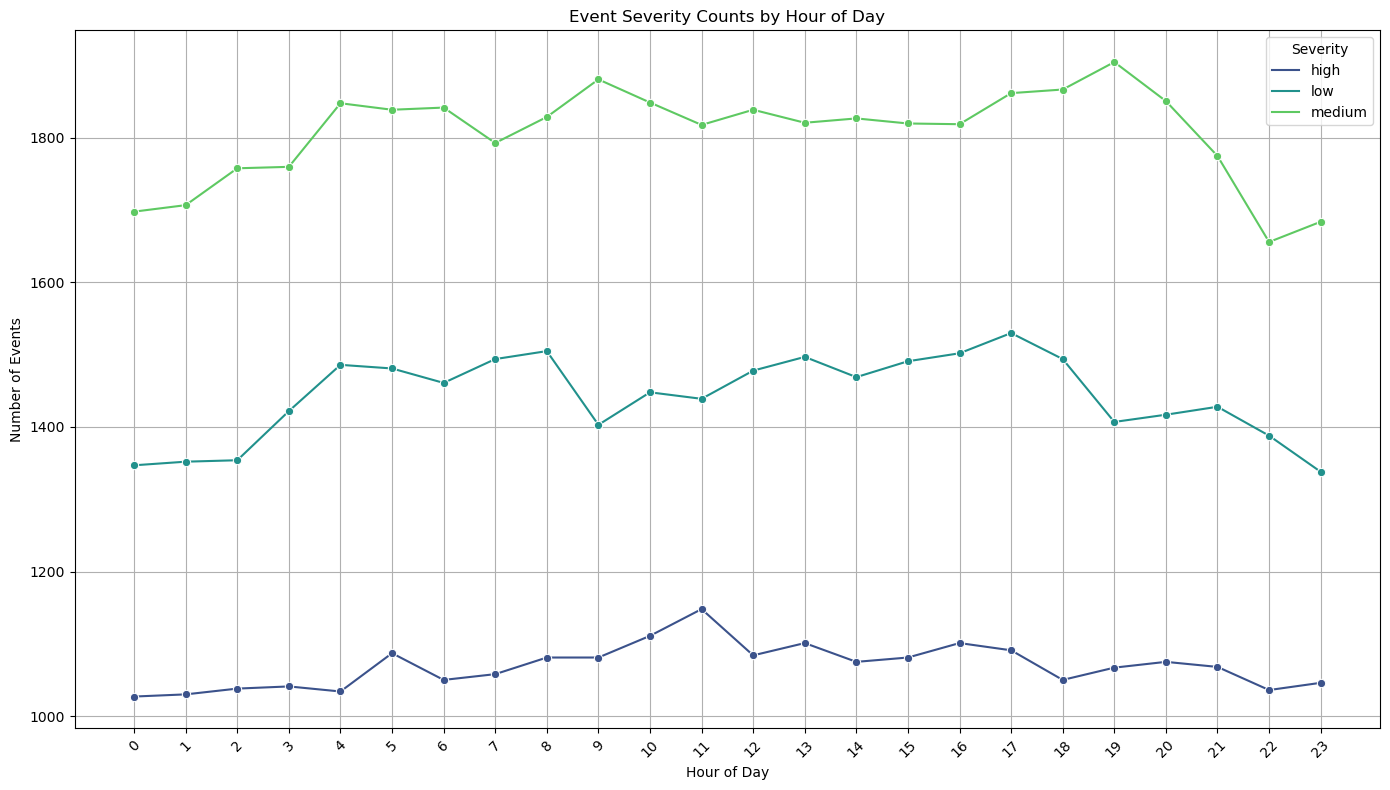

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Hour of the Day Analysis
df = df.withColumn("Hour", hour("Timestamp"))
hour_severity_counts = df.groupBy("Hour", "Severity").count()
hour_severity_pd = hour_severity_counts.toPandas()
hour_severity_pd.sort_values(['Hour', 'Severity'], inplace=True)
hour_severity_pd['Hour'] = hour_severity_pd['Hour'].astype(str)

# Plotting the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=hour_severity_pd, x='Hour', y='count', hue='Severity', marker='o', palette='viridis')
plt.title('Event Severity Counts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Severity')
plt.tight_layout()
plt.savefig('event_severity_counts_by_hour.png')
plt.show()


### Event Type vs Severity 

This is a matrix to show which combination of event type and event severity have how much relation/frequency.

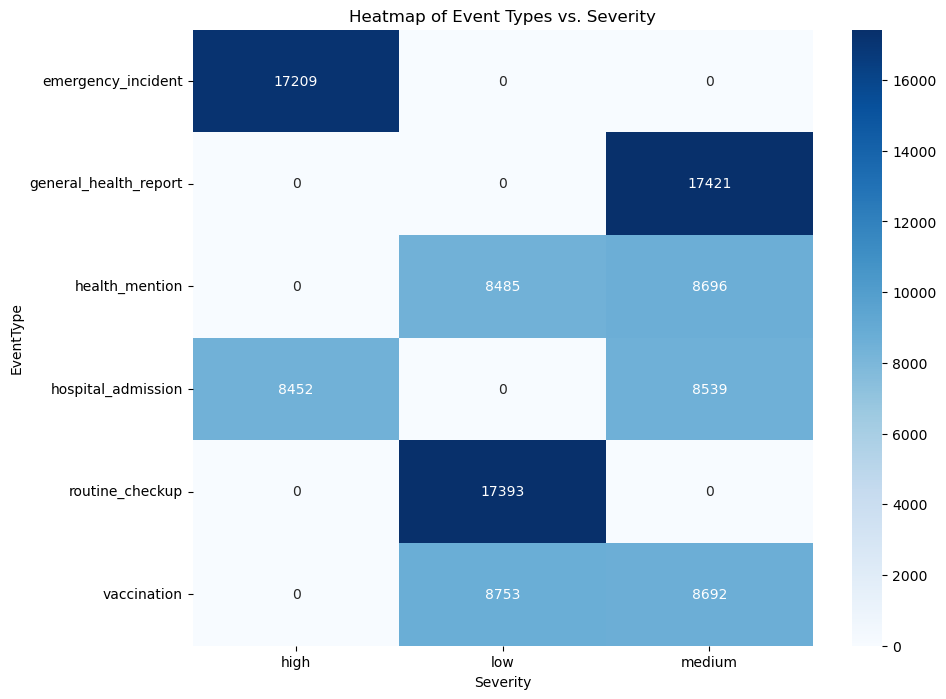

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Event Type and Severity Analysis
event_type_severity_counts = df.groupBy("EventType", "Severity").count()
event_type_severity_pd = event_type_severity_counts.toPandas()
event_type_severity_pivot = event_type_severity_pd.pivot(index='EventType', columns='Severity', values='count').fillna(0)

# Plotting the data
plt.figure(figsize=(10, 8))
sns.heatmap(event_type_severity_pivot, annot=True, cmap='Blues', fmt=".0f")
plt.title('Heatmap of Event Types vs. Severity')
plt.xlabel('Severity')
plt.ylabel('EventType')
plt.savefig('heatmap_event_types_severity.png')
plt.show()


### Multivariate Aggregate Analysis of Event Severity and Type

We can observe that emergency_incidents has all high severity events while general_health_reports have all medium severity events and routine checkups have low severity events. This makes sense.

<Figure size 1200x800 with 0 Axes>

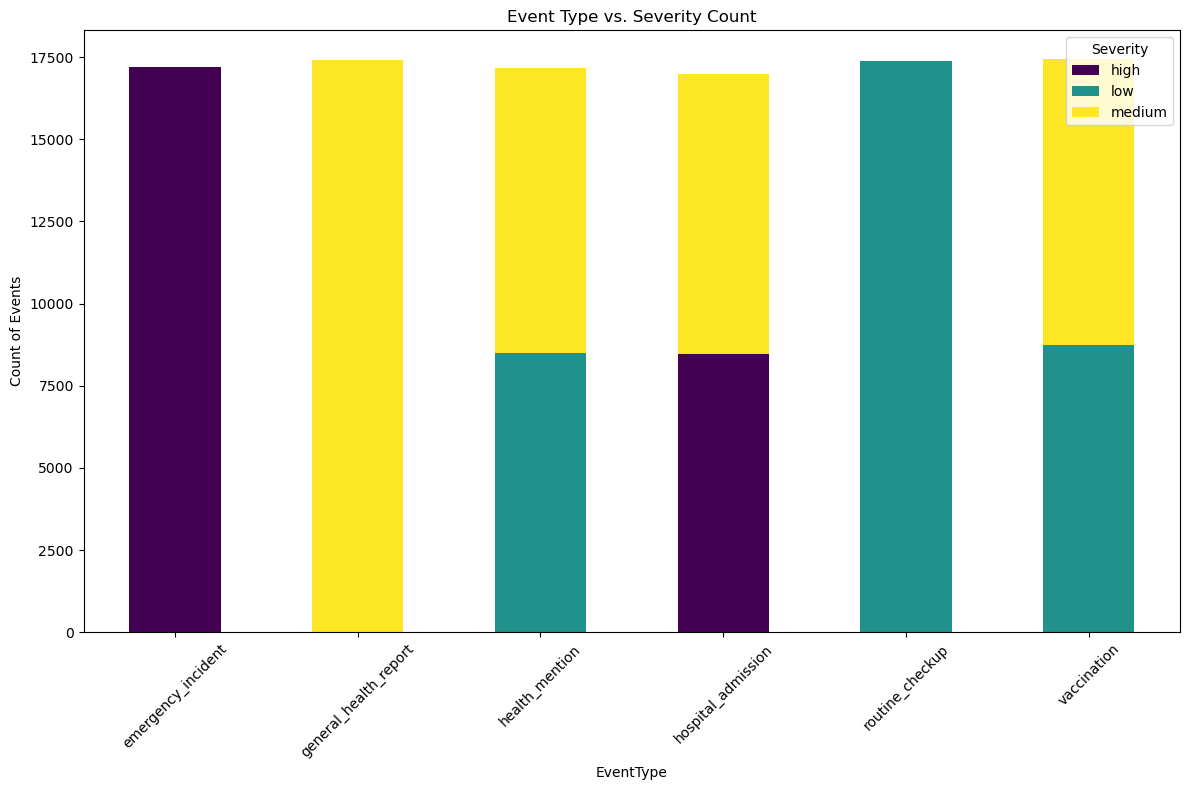

In [18]:
# Stacked Bar Chart of Event Types and Severity
plt.figure(figsize=(12, 8))
event_type_severity_pivot.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
plt.title('Event Type vs. Severity Count')
plt.xlabel('EventType')
plt.ylabel('Count of Events')
plt.xticks(rotation=45)
plt.legend(title='Severity')
plt.tight_layout()
plt.savefig('stacked_bar_event_types_severity.png')
plt.show()


### Multivariate Analysis of Event Severity and Type across Hours of Day

This is a detailed analysis for each event type and their seveirty occuring across hours of the day

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a fut

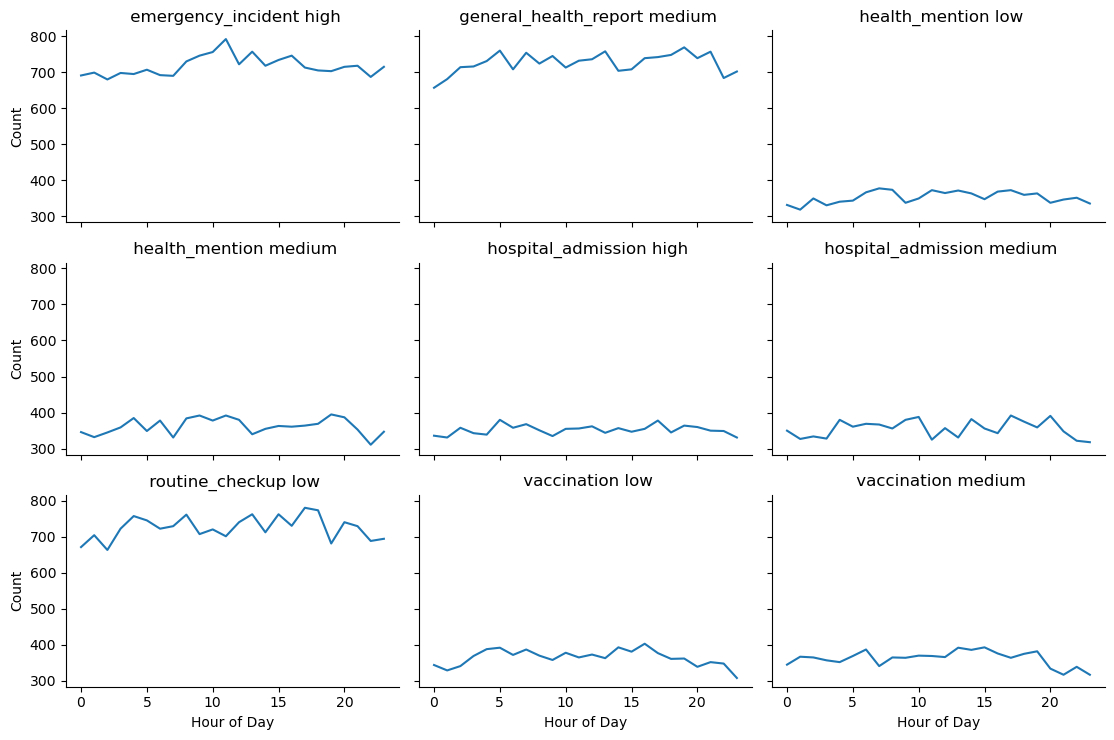

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Hour of the Day and Event Type Analysis
df = df.withColumn("Hour", hour("Timestamp"))
hour_event_severity_counts = df.groupBy("Hour", "EventType", "Severity").count()
hour_event_severity_pd = hour_event_severity_counts.toPandas()
hour_event_severity_pd.sort_values(['Hour', 'EventType', 'Severity'], inplace=True)

# pivot table for combining event types and severity
pivot_df = hour_event_severity_pd.pivot_table(index='Hour', columns=['EventType', 'Severity'], values='count', fill_value=0)
pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]
pivot_df.reset_index(inplace=True)

# Plotting the data
g = sns.FacetGrid(pivot_df.melt(id_vars=['Hour']), col="variable", col_wrap=3, height=2.5, aspect=1.5)
g.map(sns.lineplot, 'Hour', 'value')

for ax in g.axes.flat:
    ax.set_title(ax.get_title().split('=')[1])
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Count')
plt.tight_layout()

plt.savefig('facetgrid_event_types_severity_by_hour.png')
plt.show()


### Basic Aggregate Visualizations

1. Percentage variation of event types
2. Frequency of Events at different locations
3. Count of events over time

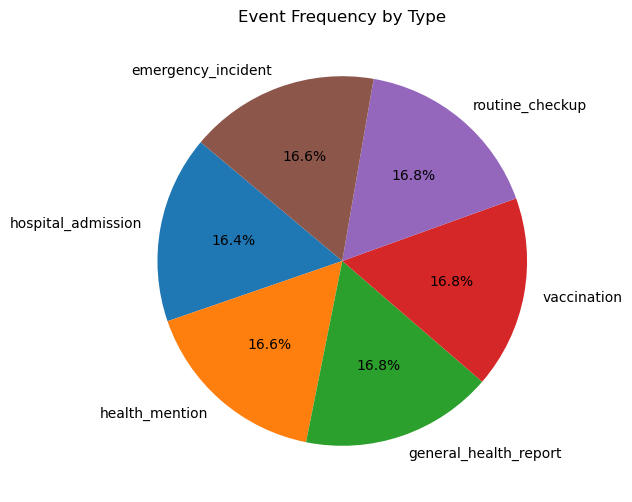

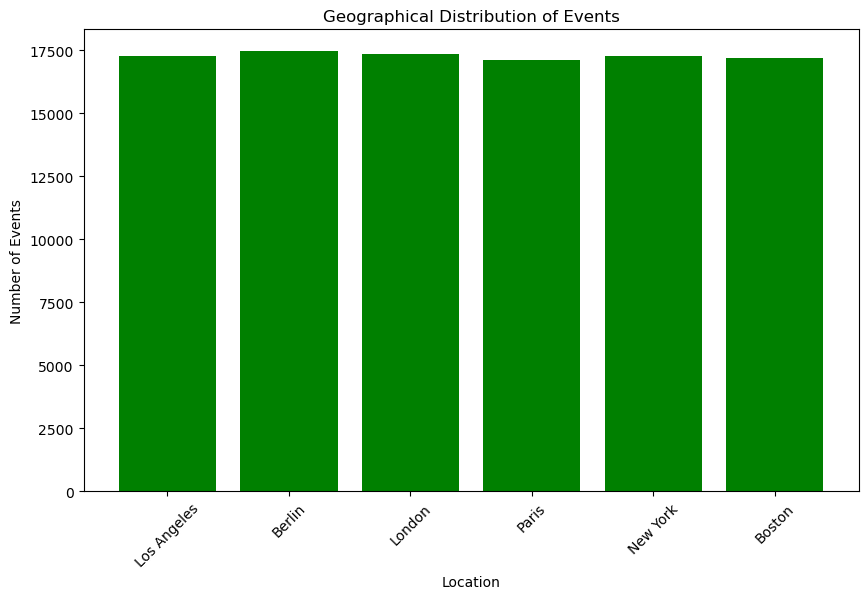

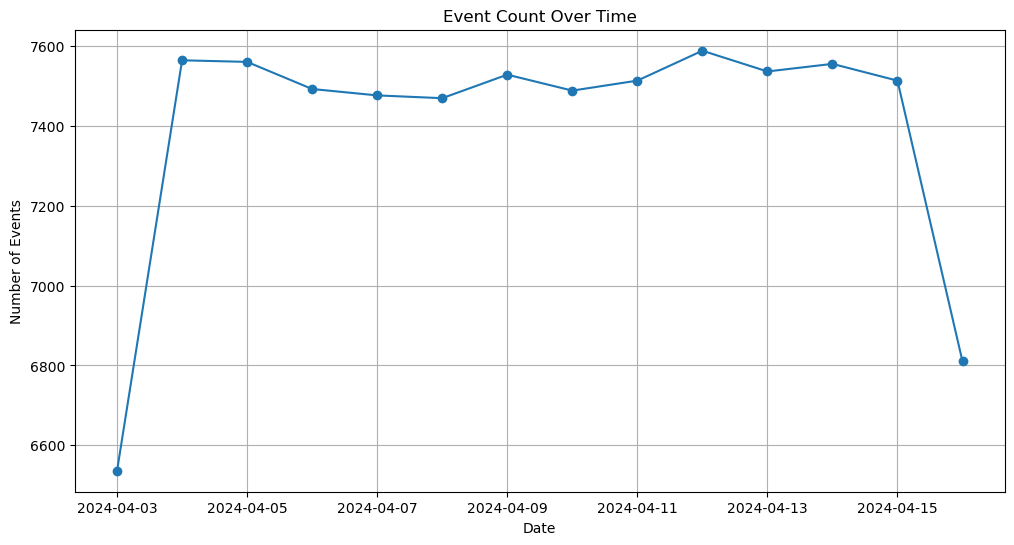

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date

# Event Frequency by Type
event_type_freq_pd = event_type_freq.toPandas()
location_freq_pd = location_freq.toPandas()

# Plotting the data
# Event Frequency by Type
plt.figure(figsize=(6, 6))
plt.pie(event_type_freq_pd['count'], labels=event_type_freq_pd['EventType'], autopct='%1.1f%%', startangle=140)
plt.title('Event Frequency by Type')
plt.savefig('event_frequency_by_type.png') 
plt.show()

#--------------------------------------------
# Geographical Distribution
plt.figure(figsize=(10, 6))
plt.bar(location_freq_pd['Location'], location_freq_pd['count'], color='green')
plt.xlabel('Location')
plt.ylabel('Number of Events')
plt.title('Geographical Distribution of Events')
plt.savefig('geographical_distribution.png')
plt.xticks(rotation=45)
plt.show()

#--------------------------------------------
# Cross-tabulation of Event Types and Locations
df = df.withColumn("Date", to_date("Timestamp"))
time_series_data = df.groupBy("Date").count().orderBy("Date")
time_series_pd = time_series_data.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(time_series_pd['Date'], time_series_pd['count'], marker='o', linestyle='-')
plt.title('Event Count Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.grid(True)
plt.savefig('event_count_over_time.png')
plt.show()


### Calculating Event Impact on Cities

We aimed to calculate which cities have the most events and were most impacted.

We assigned a score to the Severity Scale with the following values:
- 1 = Low
- 2 = Medium
- 3 = High

We then aggregated the data to get a weighted average based on event severity and its count for different locations.

In the final output, we see the normalized ranks for each city:

| Location    | Normalized Rank |
|-------------|-----------------|
| Boston      | 0.1667          |
| Paris       | 0.3333          |
| Berlin      | 0.5000          |
| New York    | 0.6667          |
| Los Angeles | 0.8333          |
| London      | 1.0000          |

From the table, we can see that **London is the most affected** city, while **Boston is the least affected**.


In [21]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as sum_


# assign severity score
from pyspark.sql.functions import when

df = df.withColumn("SeverityScore", when(df["Severity"] == "low", 1)
                     .when(df["Severity"] == "medium", 2)
                     .when(df["Severity"] == "high", 3)) 

# count avg of severity at location
location_severity_avg = df.groupBy("Location").avg("SeverityScore")
location_severity_avg.show()


severity_sums = df.groupBy("Location").agg(
    sum_("SeverityScore").alias("TotalSeverityScore"),
    sum_(col("SeverityScore") / col("SeverityScore")).alias("EventCount")
)

# Calculate weighted average of severity score
weighted_severity = severity_sums.withColumn(
    "WeightedAverageSeverity",
    col("TotalSeverityScore") / col("EventCount")
)

weighted_severity.show()

# normalize location weightedAverageSeverity
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

# Create a Window specification
window_spec = Window.orderBy(col("WeightedAverageSeverity").desc())

# Add a rank column
ranked_severity = weighted_severity.withColumn("Rank", rank().over(window_spec))

# Normalize the rank
total_locations = weighted_severity.count()
normalized_severity = ranked_severity.withColumn(
    "NormalizedRank", col("Rank") / total_locations
)

# Show the normalized ranks
normalized_severity.show()





+-----------+------------------+
|   Location|avg(SeverityScore)|
+-----------+------------------+
|Los Angeles|1.9108962482630847|
|     Berlin|1.9145132641952674|
|     London|1.9066628208826075|
|      Paris|1.9156140350877193|
|   New York|1.9120624819207406|
|     Boston|1.9210235533585345|
+-----------+------------------+

+-----------+------------------+----------+-----------------------+
|   Location|TotalSeverityScore|EventCount|WeightedAverageSeverity|
+-----------+------------------+----------+-----------------------+
|Los Angeles|             33005|   17272.0|     1.9108962482630847|
|     Berlin|             33414|   17453.0|     1.9145132641952674|
|     London|             33052|   17335.0|     1.9066628208826075|
|      Paris|             32757|   17100.0|     1.9156140350877193|
|   New York|             33050|   17285.0|     1.9120624819207406|
|     Boston|             33032|   17195.0|     1.9210235533585345|
+-----------+------------------+----------+--------------

### Geographical Visualizations

We get the list of cities in our dataset and add their coordinates to our dataframe to do visualization via geopandas

In [22]:
# list of unique locations
locations = df.select("Location").distinct().rdd.flatMap(lambda x: x).collect()

In [23]:
# create dictionary of coordinates for each location
location_coords = {
    "Boston": (42.3601, -71.0589),
    "Berlin": (52.5200, 13.4050),
    "New York": (40.7128, -74.0060),
    "Los Angeles": (34.0522, -118.2437),
    "Paris": (48.8566, 2.3522),
    "London": (51.5074, -0.1278)
}

#add coordinates to dataframe by mapping location to coordinates
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

def get_coords(location):
    return location_coords[location]

get_coords_udf = udf(get_coords, ArrayType(FloatType()))

df = df.withColumn("Coords", get_coords_udf(df["Location"]))
df.show()

+------------------+-------------------+-----------+--------+----------+--------+---------+----+-------------+--------------------+
|         EventType|          Timestamp|   Location|Severity|      Date|    Time|DayOfWeek|Hour|SeverityScore|              Coords|
+------------------+-------------------+-----------+--------+----------+--------+---------+----+-------------+--------------------+
|   routine_checkup|2024-04-03 02:14:33|      Paris|     low|2024-04-03|02:14:33|Wednesday|   2|            1|   [48.8566, 2.3522]|
|emergency_incident|2024-04-03 02:14:52|     Boston|    high|2024-04-03|02:14:52|Wednesday|   2|            3| [42.3601, -71.0589]|
|hospital_admission|2024-04-03 02:15:12|Los Angeles|  medium|2024-04-03|02:15:12|Wednesday|   2|            2|[34.0522, -118.2437]|
|emergency_incident|2024-04-03 02:15:29|Los Angeles|    high|2024-04-03|02:15:29|Wednesday|   2|            3|[34.0522, -118.2437]|
|   routine_checkup|2024-04-03 02:15:47|      Paris|     low|2024-04-03|02:1